### OCR Visualization
The goal here is to generate labels the OpenTT dataset for the score. I used two different coordinate sets to crop the score board for the table tennis video sets, then run OCR on the croppend to see if I could improve the ocr.

First I used these coordinates:
```
 scoreboard_coords = {
     "game_1.mp4": {"player_1": (915, 398, 24, 26), "player_2": (940, 399, 21, 26)},
     "game_2.mp4": {"player_1": (999, 507, 22, 24), "player_2": (1024, 508, 21, 24)},
     "game_3.mp4": {"player_1": (877, 435, 22, 27), "player_2": (901, 435, 23, 26)},
     "game_4.mp4": {"player_1": (905, 433, 23, 27), "player_2": (927, 433, 25, 27)},
     "game_5.mp4": {"player_1": (932, 410, 27, 28), "player_2": (957, 410, 25, 28)},
 }
 ```
 but I noticed after reviewing some of the scores quickly that many of the scores didn't make sense. After reviewing some of the footage, I noticed two main problems: the ocr was having trouble because the bounding boxes werent tight enough

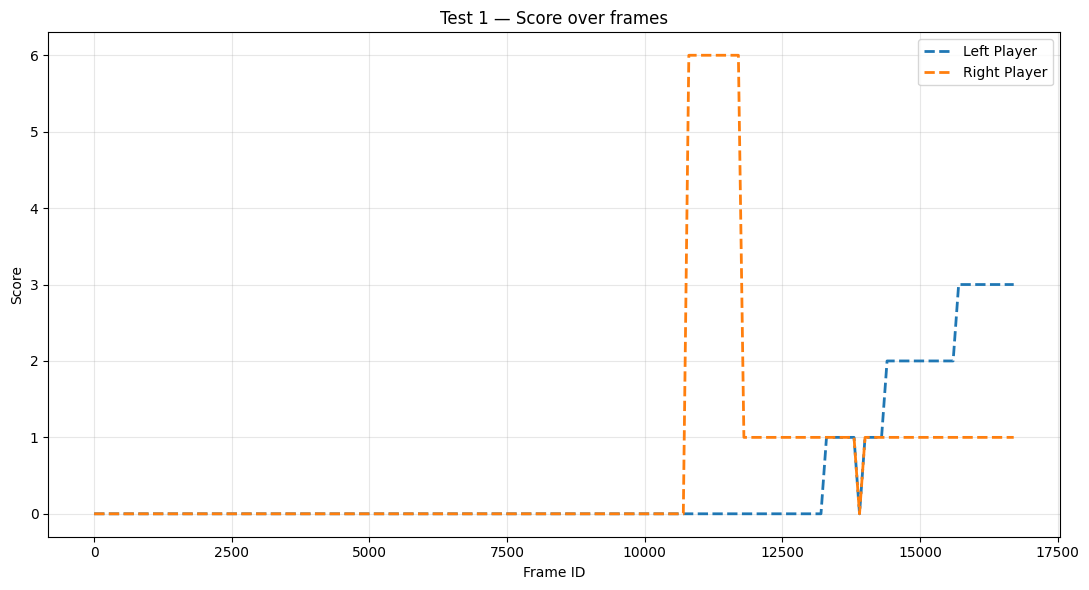

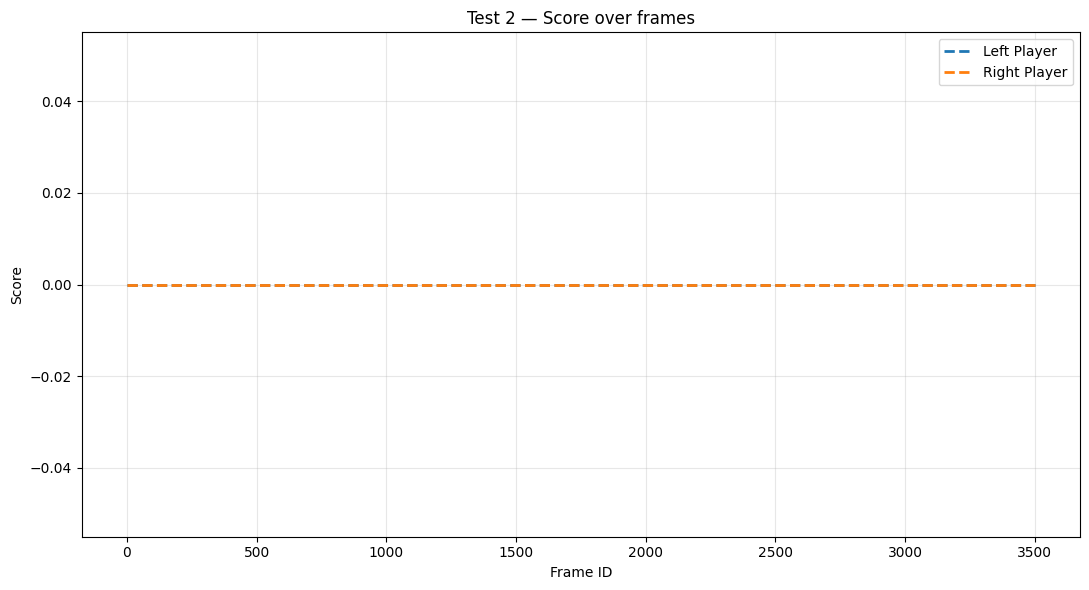

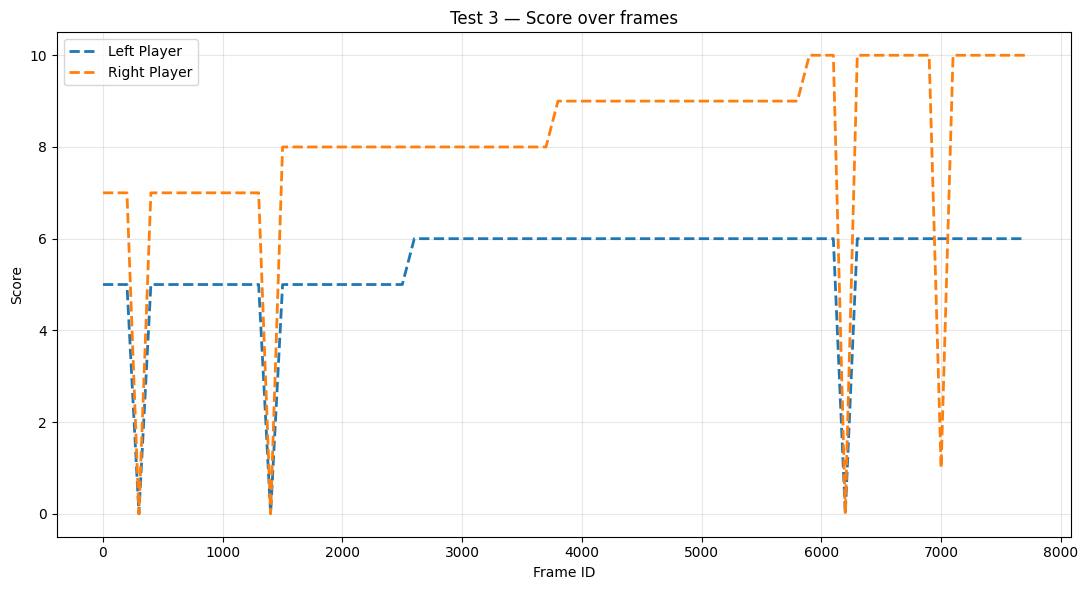

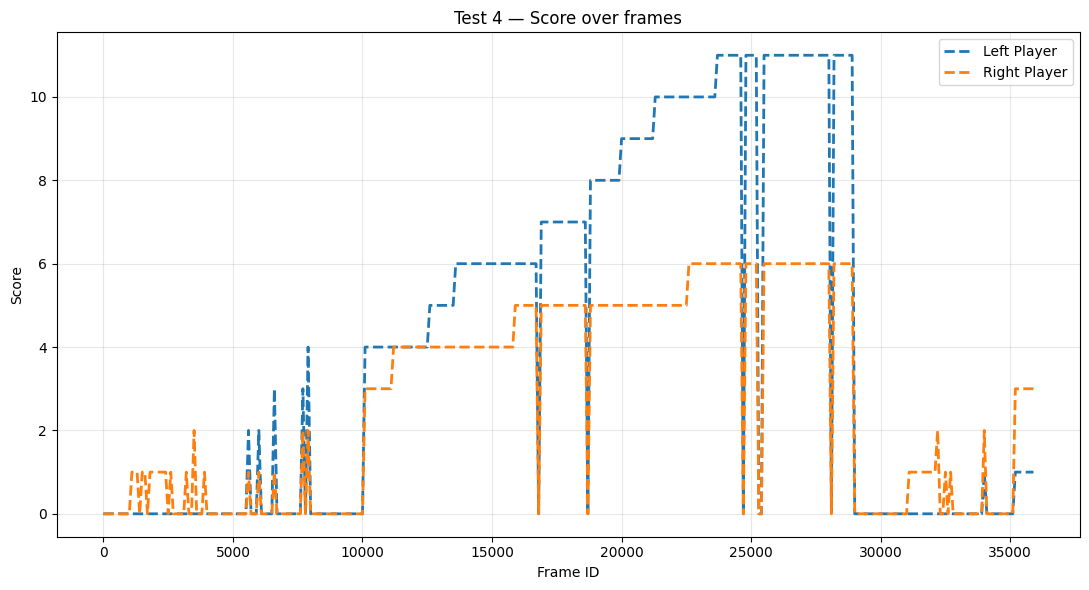

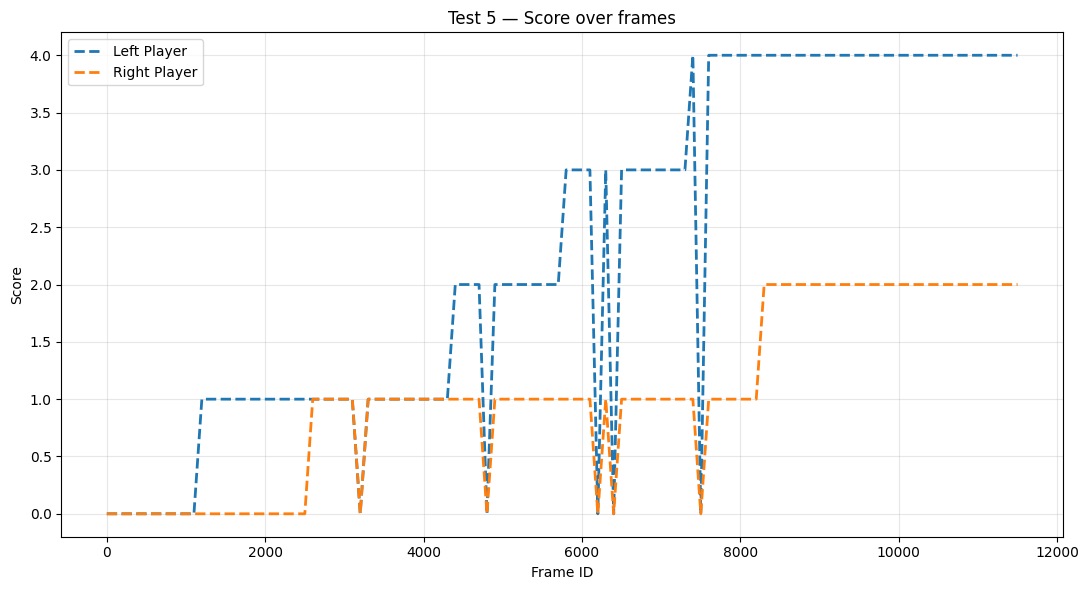

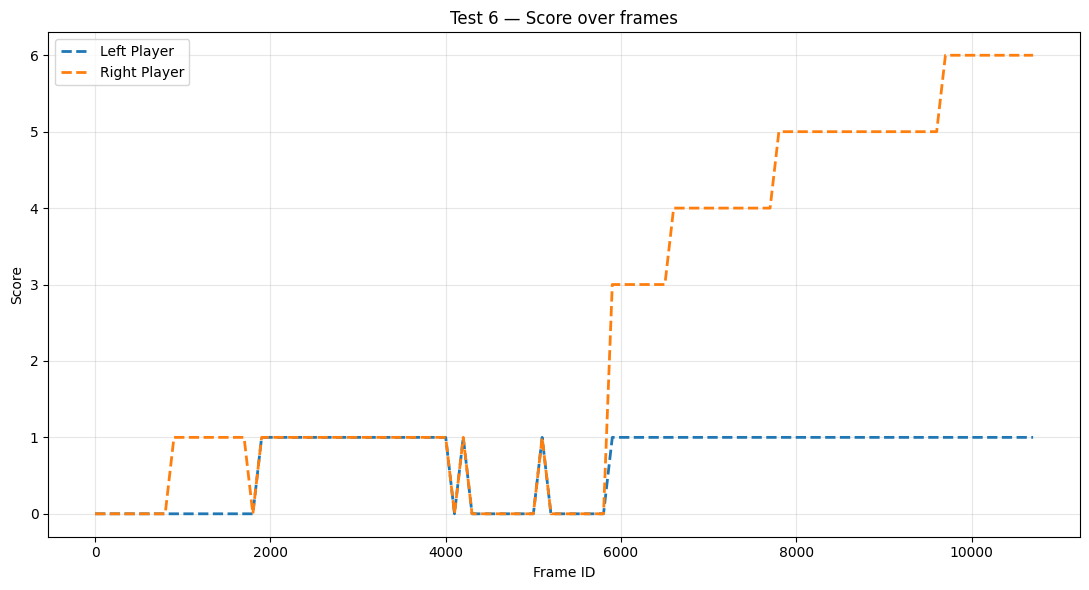

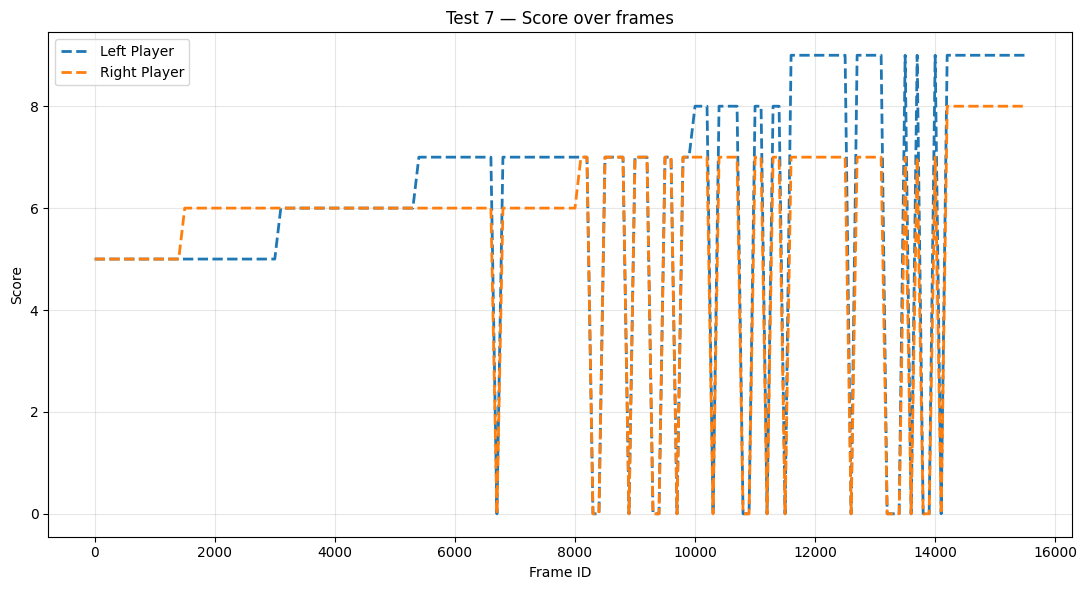

In [2]:
#!/usr/bin/env python3
import csv
import re
from pathlib import Path

import matplotlib.pyplot as plt

LABELS_DIR = Path("./labels")

# games to process
GAMES = [1, 2, 3, 4, 5, 6, 7]

SCORE_RX = re.compile(r"^\s*(\d+)\s*-\s*(\d+)\s*$")

def parse_score(cell: str):
    """Return (p1, p2) from 'N-M'; blanks/invalid -> (0,0)."""
    if not cell:
        return 0, 0
    m = SCORE_RX.match(cell)
    if not m:
        return 0, 0
    return int(m.group(1)), int(m.group(2))

def read_csv_scores(path: Path):
    """Return lists x=frames, y1=P1, y2=P2 from a labels CSV."""
    frames, p1s, p2s = [], [], []
    if not path.exists():
        return frames, p1s, p2s
    with path.open(newline="") as f:
        reader = csv.reader(f)
        header = next(reader, None)  # ['frame','score']
        for row in reader:
            if not row:
                continue
            try:
                frame = int(row[0])
            except Exception:
                continue
            p1, p2 = parse_score(row[1].strip() if len(row) > 1 else "")
            frames.append(frame)
            p1s.append(p1)
            p2s.append(p2)
    # sort by frame (just in case)
    order = sorted(range(len(frames)), key=lambda i: frames[i])
    frames = [frames[i] for i in order]
    p1s = [p1s[i] for i in order]
    p2s = [p2s[i] for i in order]
    return frames, p1s, p2s

def plot_game(game_idx: int):
    game_path = f"scores/test_{game_idx}_scores.csv"

    full_game_path = LABELS_DIR / game_path
    frames, left_player, right_player = read_csv_scores(full_game_path)

    plt.figure(figsize=(11, 6))
    plt.title(f"Test {game_idx} — Score over frames")

    plt.plot(frames, left_player, linestyle="--", label="Left Player", linewidth=2)
    plt.plot(frames, right_player, linestyle="--", label="Right Player", linewidth=2)

    plt.xlabel("Frame ID")
    plt.ylabel("Score")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def main():
    for g in GAMES:
        plot_game(g)

if __name__ == "__main__":
    main()
